In [44]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TextClassificationPipeline
import shap
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
from datasets import load_metric

In [45]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2, output_attentions=True)

model.load_state_dict(torch.load('Models/model_clean_2.pth'))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

model.eval()

# example text input
text = "Chronic kidney disease is a general term for heterogeneous disorders affecting kidney structure and function"


encoding = tokenizer.encode_plus(
    text,
    max_length=256,
    padding='max_length',
    return_token_type_ids=False,
    return_attention_mask=True,
    return_tensors='pt',
    truncation=True
)

input_ids = encoding['input_ids'].to(device)
attention_mask = encoding['attention_mask'].to(device)

with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    prediction = "Medical" if predicted_class == 1 else "Non-Medical"

print(f"Predicted class: {prediction}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\gavin\AppData\Local\Temp\ipykernel_192856\652421292.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless the

Predicted class: Medical


In [46]:
new_text = "In this study, we presented a novel conjugation chemistry for developing enhanced KPC2 enzyme testing at POC settings using SPEs-based electrochemical immunoassay [44]. Our approach relied on a site-directed reaction that used a heterobifunctional PEG polymer to link oxidized polyclonal anti-KPC2 antibodies to the surface of Au-SPEs. We achieved PEGylation of the Au-SPE using SH-PEG-hydrazide, which left the hydrazide groups free to react with the oxidized Fc regions of anti-KPC2 polyclonal antibodies. Our results demonstrated that this site-directed conjugation approach offered a viable alternative to traditional NHS-based chemistry for the modification of Au-SPEs with antibodies. By using directional conjugation, we were able to obtain highly efficient and specific binding of the antibody to the enzyme, which is crucial for designing and developing accurate detection of KPC2."
# new_text ="This paper presents a novel method on building relationship between the vision features of the terrain images and the terrain traversability which manifests the difficulty of field robot traveling across one terrain. Vision features of the image are extracted based on color and texture. The travesability is labeled with the relative vibration. The support vector machine regression method is adopted to build up the inner relationship between them. In order to avoid the over-learning during training, k-fold method is used and average mean square error is defined as the target minimized to get the optimal parameters based on parameter space grid method. For the traveling smoothness of field robot, the original traversability prediction is transformed to computed traversability prediction based on different initial sub-regions. The optimal path is given by minimizing the sum of computed traversability prediction of all sub-regions in each path. Three experiments are discussed to demonstrate the effectiveness and efficiency of the method mentioned in this paper."
def predicted_text(model, tokenizer, text, device):
    model.eval()  # Set model to evaluation mode

    # Tokenize the input text
    inputs = tokenizer(text, return_tensors='pt', add_special_tokens=False, truncation=True, max_length=64).to(device)
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].cpu().numpy())  
    num_tokens = len(tokens)
    
    # Forward pass to get hidden states and attentions
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True, output_attentions=True)
        logits = outputs.logits
        print(logits)
        predicted_class = torch.argmax(logits, dim=1).item()
        prediction = "Medical" if predicted_class == 1 else "Non-Medical"
    return prediction
predicted_text(model, tokenizer, new_text, device)

tensor([[0.0605, 0.1628]], device='cuda:0')


'Medical'

### Shap

In [47]:
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True, device=0)
def score_and_visualize(text):
    prediction = pipe([text])
    print(prediction[0])

    explainer = shap.Explainer(pipe)
    shap_values = explainer([text])

    shap.plots.text(shap_values)
    

score_and_visualize(new_text)

[{'label': 'LABEL_0', 'score': 0.1434115469455719}, {'label': 'LABEL_1', 'score': 0.8565884828567505}]


## Get the attentionsss of each token

tensor([[-0.8895,  1.2471]], device='cuda:0')


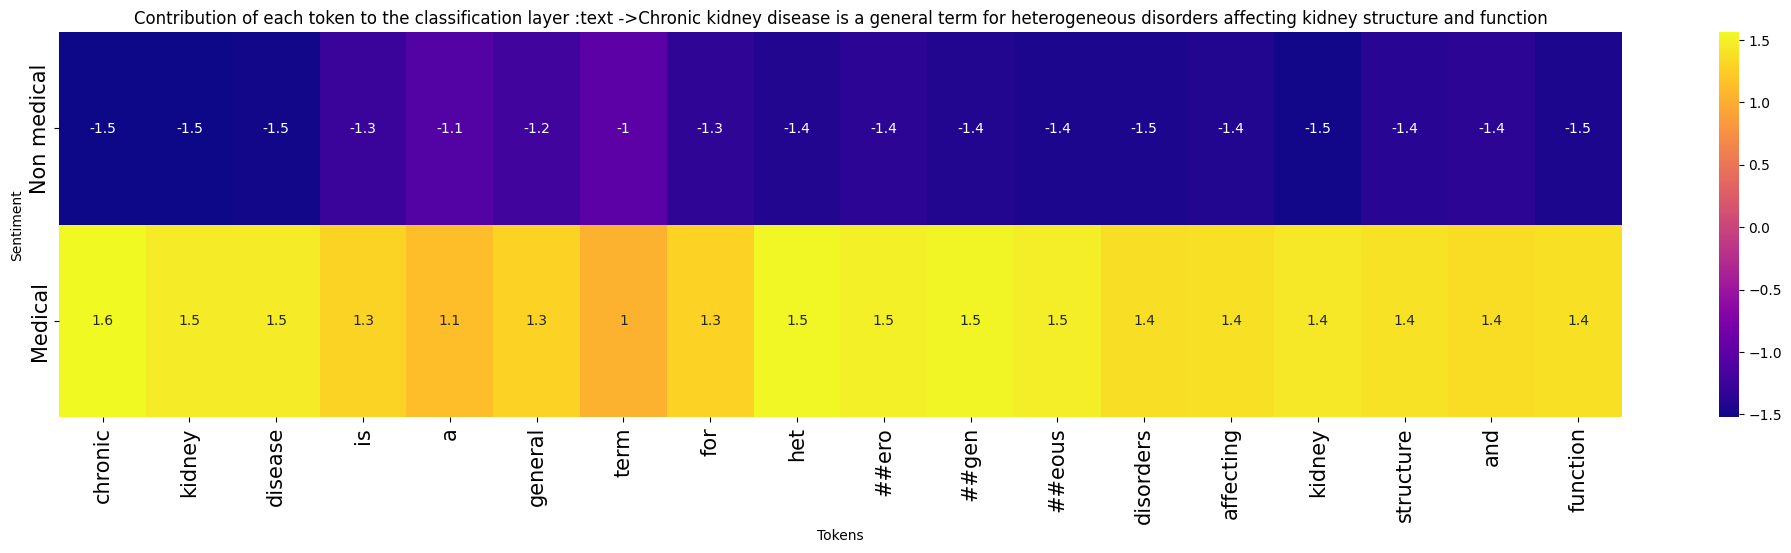

In [48]:
def get_attentions_token(model, tokenizer, text, device):
    model.eval()  # Set model to evaluation mode

    # Tokenize the input text
    inputs = tokenizer(text, return_tensors='pt', add_special_tokens=False, truncation=True, max_length=64).to(device)
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].cpu().numpy())  
    num_tokens = len(tokens)
    
    # Forward pass to get hidden states and attentions
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True, output_attentions=True)
    
    print(outputs.logits)
    # Get the last hidden state and pass it through the pre-classifier and classifier
    last_hidden_state = outputs.hidden_states[-1].squeeze(0)
    pre_c = model.pre_classifier(last_hidden_state)
    classifie = model.classifier(pre_c).cpu().detach().numpy()

    # Adjust figure size dynamically based on the number of tokens
    fig, ax = plt.subplots(figsize=(num_tokens*1.4, 5))
    
    # Generate heatmap with label annt
    sns.heatmap(classifie.T, cmap='plasma', xticklabels=tokens, yticklabels=['Non medical','Medical'], annot=True)
    plt.title(f"Contribution of each token to the classification layer :text ->{text}")
    plt.xlabel("Tokens")
    plt.ylabel("Sentiment")
    plt.xticks(rotation=90)
    # make the text of the labels larger
    plt.tick_params(axis='both', which='major', labelsize=15)

    plt.show()

    # save the plot
    fig.savefig('attention.png')

# Visualize attention of all token toward the logits
get_attentions_token(model, tokenizer, "Chronic kidney disease is a general term for heterogeneous disorders affecting kidney structure and function", device)

tensor([[-0.6844,  1.0049]], device='cuda:0')


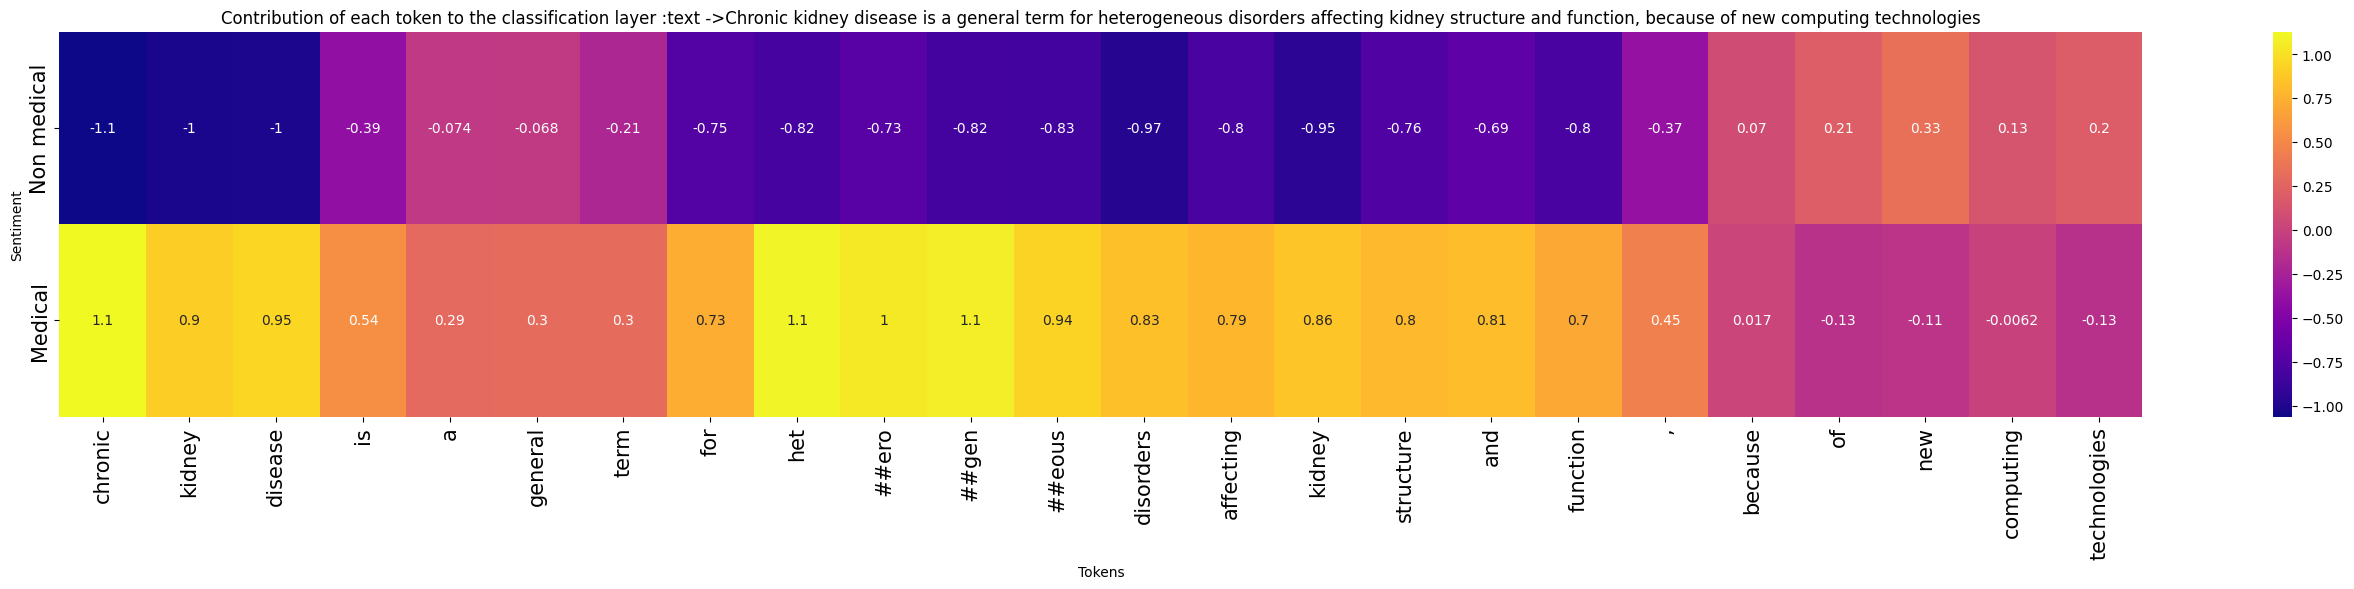

In [49]:
get_attentions_token(model, tokenizer, "Chronic kidney disease is a general term for heterogeneous disorders affecting kidney structure and function, because of new computing technologies", device)

tensor([[0.0605, 0.1628]], device='cuda:0')


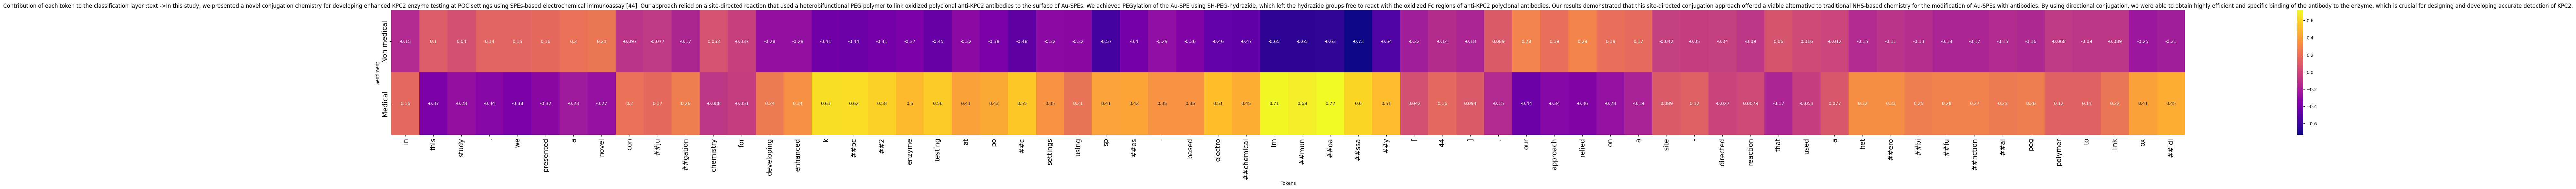

In [50]:
get_attentions_token(model, tokenizer, new_text, device)